# Community Detection in FriendFeed Network - Optimized for Low Memory

This notebook focuses on preparing the graph for detecting communities within the FriendFeed social network
with limited memory resources.

In [1]:

## 1. Import Libraries and Load Data
import dask.dataframe as dd
import igraph as ig
import leidenalg
import gc
import numpy as np
import time
from collections import Counter, defaultdict
import matplotlib.pyplot as plt
import warnings

# Plotting settings
%matplotlib inline
warnings.filterwarnings("ignore", category=FutureWarning)

# Start timing
start_time = time.time()

# Load preprocessed data with Dask
users = dd.read_parquet('processed_data/users_cleaned.parquet')
subs = dd.read_parquet('processed_data/subs_cleaned.parquet')
following = dd.read_parquet('processed_data/following_cleaned.parquet')
comments = dd.read_parquet('processed_data/comments_cleaned.parquet')
likes = dd.read_parquet('processed_data/likes_cleaned.parquet')
entries = dd.read_parquet('processed_data/entries_cleaned.parquet')

# Verify that all user IDs in interactions exist in the users DataFrame
def verify_user_ids(interaction_df, user_column_name):
    interaction_user_ids = set(interaction_df[user_column_name].unique().compute())
    user_ids = set(users['ID'].unique().compute())
    missing_user_ids = interaction_user_ids - user_ids
    print(f"Number of user IDs in '{user_column_name}' not in 'users': {len(missing_user_ids)}")
    if len(missing_user_ids) > 0:
        print(f"Sample of missing user IDs: {list(missing_user_ids)[:10]}")

# Run verification
verify_user_ids(likes, 'userID')
verify_user_ids(entries, 'PostedBy')


Number of user IDs in 'userID' not in 'users': 0
Number of user IDs in 'PostedBy' not in 'users': 0


In [2]:
# Function to print shape of Dask DataFrames
def print_dask_shape(df, name):
    row_count = df.shape[0].compute()
    col_count = len(df.columns)
    print(f"{name} shape: ({row_count}, {col_count})")

# Print shapes for each DataFrame
print_dask_shape(users, 'users')
print_dask_shape(subs, 'subs')
print_dask_shape(following, 'following')
print_dask_shape(comments, 'comments')
print_dask_shape(likes, 'likes')
print_dask_shape(entries, 'entries')


users shape: (645414, 4)
subs shape: (24761879, 2)
following shape: (18477145, 3)
comments shape: (2835155, 6)
likes shape: (427214, 3)
entries shape: (10954103, 5)


In [3]:
# Initialize the Graph
G = ig.Graph(directed=True)

# Add nodes for users
G.add_vertices(users['ID'].compute().tolist())
print(f"Graph initialized with {G.vcount()} nodes.")

# Define weights for different interaction types
interaction_weights = {'following': 1, 'subs': 1, 'like': 2, 'comment': 3}

# Helper function to add weighted edges
def add_weighted_edges(df, source_col, target_col, relationship_type):
    # Retrieve source-target pairs and compute them in-memory
    edges = df[[source_col, target_col]].compute().values
    weight = interaction_weights[relationship_type]
    
    # Ensure we pass only pairs for edges
    G.add_edges([(edge[0], edge[1]) for edge in edges])  
    # Assign weights and relationship type attributes
    G.es[-len(edges):]['relationship'] = relationship_type
    G.es[-len(edges):]['weight'] = [weight] * len(edges)  # Set weight for each added edge
    print(f"Added {len(edges)} '{relationship_type}' edges with weight {weight}. Total edges: {G.ecount()}")

# Add edges for 'following' and 'subs'
add_weighted_edges(following, 'FollowerID', 'FollowedID', 'following')
add_weighted_edges(subs, 'FollowerID', 'FollowedID', 'subs')

# Prepare mappings for post authors
post_author_entries = dict(zip(entries['PostID'].compute(), entries['PostedBy'].compute()))
post_author_comments = dict(zip(comments['PostID'].compute(), comments['PostedBy'].compute()))
post_author_mapping = {**post_author_entries, **post_author_comments}

# Filter out edges with None values for 'like' edges
likes_edges = [(row['userID'], post_author_mapping.get(row['PostID'])) for _, row in likes.iterrows()]
likes_edges = [(source, target) for source, target in likes_edges if source is not None and target is not None]

# Add to graph with weight for 'like'
G.add_edges(likes_edges)
G.es[-len(likes_edges):]['relationship'] = 'like'
G.es[-len(likes_edges):]['weight'] = [interaction_weights['like']] * len(likes_edges)
print(f"Added {len(likes_edges)} 'like' edges with weight {interaction_weights['like']}. Total edges: {G.ecount()}")

# Clear intermediate variables to free memory
del likes_edges
gc.collect()

# Filter out edges with None values for 'comment' edges
comments_edges = [(row['PostedBy'], post_author_entries.get(row['EntryID'])) for _, row in comments.iterrows()]
comments_edges = [(source, target) for source, target in comments_edges if source is not None and target is not None]

# Add to graph with weight for 'comment'
G.add_edges(comments_edges)
G.es[-len(comments_edges):]['relationship'] = 'comment'
G.es[-len(comments_edges):]['weight'] = [interaction_weights['comment']] * len(comments_edges)
print(f"Added {len(comments_edges)} 'comment' edges with weight {interaction_weights['comment']}. Total edges: {G.ecount()}")

Graph initialized with 645414 nodes.
Added 18477145 'following' edges with weight 1. Total edges: 18477145
Added 24761879 'subs' edges with weight 1. Total edges: 43239024
Added 370687 'like' edges with weight 2. Total edges: 43609711
Added 2623974 'comment' edges with weight 3. Total edges: 46233685


In [4]:
# Remove self-loops by selecting edges where the source and target vertices are the same
self_loop_edges = G.es.select(lambda e: e.source == e.target)
G.delete_edges(self_loop_edges)

print(f"Graph has {G.vcount()} nodes and {G.ecount()} edges after removing self-loops.")


Graph has 645414 nodes and 44671399 edges after removing self-loops.


In [5]:
## 3. Community Detection with Leiden Algorithm
# Run the Leiden algorithm
partition = leidenalg.find_partition(G, leidenalg.ModularityVertexPartition, weights='weight')
print(f"Number of communities detected: {len(set(partition.membership))}")


Number of communities detected: 4850


In [6]:
# Map each node to its community
community_mapping = dict(zip(G.vs['name'], partition.membership))
# Calculate and display community sizes
community_sizes = Counter(partition.membership)
top_communities = community_sizes.most_common(10)
for comm_id, size in top_communities:
    print(f"Community {comm_id}: {size} nodes")

Community 0: 201709 nodes
Community 1: 72860 nodes
Community 2: 70520 nodes
Community 3: 67966 nodes
Community 4: 33486 nodes
Community 5: 32240 nodes
Community 6: 30382 nodes
Community 7: 21538 nodes
Community 8: 19152 nodes
Community 9: 17363 nodes


In [7]:
# length of the communities
print(f"Length of the communities: {len(community_sizes)}")

Length of the communities: 4850


In [8]:
# Count the number of communities with fewer than 2 nodes
count_small_communities = sum(1 for size in community_sizes.values() if size < 2)

print(f"Number of communities with fewer than 2 nodes: {count_small_communities}")


Number of communities with fewer than 2 nodes: 2045


In [ ]:
# ids of top 10 nodes
top_nodes = [int(node['name']) for node in G.vs if node.index in [node.index for node in G.vs.select(_degree = G.maxdegree())]]
print(f"Top 10 nodes by degree: {top_nodes}")

# Get the community ID for each of the top nodes
top_nodes_communities = [community_mapping[node_id] for node_id in top_nodes]
print(f"Communities for top 10 nodes: {top_nodes_communities}")

In [38]:
# Find all community IDs with only one node
single_user_communities = [comm_id for comm_id, size in community_sizes.items() if size == 1]
print(f"Total single-user communities: {len(single_user_communities)}")

# List of user IDs in single-user communities
single_user_ids = [G.vs[node]["name"] for node, comm_id in enumerate(partition.membership) if comm_id in single_user_communities]

# Print or examine the IDs
print(f"User IDs in single-user communities: {single_user_ids}")
print(f"Total user IDs in single-user communities: {len(single_user_ids)}")



Total single-user communities: 2045
User IDs in single-user communities: ['drmnmlk', 'dudude', 'ebuu', 'elaryan', 'erenhatirnaz', 'fadetobright', 'ferideceylan', 'fmgraphics', 'forget', 'gbirkett', 'gemma', 'gmania', 'incesticide', 'informedidiot', 'irishsideofmoon', 'ivancokrajcovic', 'jack100', 'jcporter1', 'jodyengland1', 'jordi4', 'josephdsmithjr', 'juliecarr', 'earfun', 'hermielazaro', 'kamraj', 'hoboot1', 'kassyjohnson', 'katapult', 'katetanita', 'kbipropertiesllc', 'kernal', 'korhansonmezsoy', 'lazarustaylor', 'linkster', 'lizardqueen', 'lmg', 'lydiawee', 'koutheir', 'mahooch', 'marianatalavera', 'marinutri', 'markchew', 'mazdak1', 'mdryan', 'millenareis', 'miptalk', 'davideridolfi', 'azizfoladvand', 'laroussibenyacoub', 'mojoyugen', 'mustyrhymer', 'ncollette', 'no2coldcalling', 'omargatti', 'paisa', 'panzullo', 'paolacaggia', 'paulmenard', 'pcextra', 'pclifton', 'piccoloimprenditore', 'pierremarques', 'pino', 'purna', 'caxonturse', 'baykiz', 'raissazhou', 'rasoul', 'bilallekesi

In [40]:
import dask.dataframe as dd
import pandas as pd

# Load preprocessed data with Dask
users = dd.read_parquet('processed_data/users_cleaned.parquet')
subs = dd.read_parquet('processed_data/subs_cleaned.parquet')
following = dd.read_parquet('processed_data/following_cleaned.parquet')
comments = dd.read_parquet('processed_data/comments_cleaned.parquet')
likes = dd.read_parquet('processed_data/likes_cleaned.parquet')
entries = dd.read_parquet('processed_data/entries_cleaned.parquet')

def analyze_user(user_id):
    # 1. User Information
    user_info = users[users['ID'] == user_id].compute()
    if user_info.empty:
        print(f"User ID {user_id} not found in the users dataset.")
        return
    
    print("User Information:")
    print(user_info)
    print("\n")

    # 2. Subscriptions
    # Check who the user is following and who follows them
    user_subs_following = subs[subs['FollowerID'] == user_id].compute()
    user_subs_followed_by = subs[subs['FollowedID'] == user_id].compute()

    print(f"Subscriptions where user is following others: {len(user_subs_following)}")
    print(f"Subscriptions where others are following the user: {len(user_subs_followed_by)}")
    print("\n")

    # 3. Following Relationships
    user_following = following[following['FollowerID'] == user_id].compute()
    user_followed_by = following[following['FollowedID'] == user_id].compute()

    print(f"Following relationships where user follows others: {len(user_following)}")
    print(f"Following relationships where others follow the user: {len(user_followed_by)}")
    print("\n")

    # 4. Comments
    # Check if the user has made any comments
    user_comments = comments[comments['PostedBy'] == user_id].compute()
    print(f"Total comments made by user: {len(user_comments)}")
    if len(user_comments) > 0:
        print("Sample comments:")
        print(user_comments[['PostID', 'Text', 'Timestamp']].head())
    print("\n")

    # 5. Likes
    # Check if the user has liked any posts
    user_likes = likes[likes['userID'] == user_id].compute()
    print(f"Total likes by user: {len(user_likes)}")
    if len(user_likes) > 0:
        print("Sample likes:")
        print(user_likes[['PostID', 'Timestamp']].head())
    print("\n")

    # 6. Entries (Posts)
    # Check if the user has made any posts
    user_posts = entries[entries['PostedBy'] == user_id].compute()
    print(f"Total posts made by user: {len(user_posts)}")
    if len(user_posts) > 0:
        print("Sample posts:")
        print(user_posts[['PostID', 'Text', 'Timestamp']].head())
    print("\n")
    
    # Free up memory
    gc.collect()

In [47]:
# Example usage:
# Replace 'user_id_here' with the actual user ID you want to analyze
analyze_user(user_id='baranamed')

User Information:
               ID  Type        Name                   Description
310769  baranamed  user  baran amed  bruksel'de yasayan cevirmen.


Subscriptions where user is following others: 140
Subscriptions where others are following the user: 116


Following relationships where user follows others: 94
Following relationships where others follow the user: 102


Total comments made by user: 443
Sample comments:
                                                   PostID  \
206854  e/b6143c5e9e6f4f448c92cb863da62f12/c/c0ec2a366...   
207741  e/b6143c5e9e6f4f448c92cb863da62f12/c/c492059ba...   
207937  e/b6143c5e9e6f4f448c92cb863da62f12/c/70798eaf3...   
208101  e/b6143c5e9e6f4f448c92cb863da62f12/c/328eccdac...   
208340  e/b6143c5e9e6f4f448c92cb863da62f12/c/ec871565f...   

                                                     Text           Timestamp  
206854        Şerzan Kurt davasına Eskişehir yolu gözüktü 2010-08-10 18:06:50  
207741                                            

# Community Detection in FriendFeed Network - Optimized for Low Memory

This notebook focuses on preparing the graph for detecting communities within the FriendFeed social network
with limited memory resources.

In [ ]:

## 1. Import Libraries and Load Data
import dask.dataframe as dd
import igraph as ig
import leidenalg
import gc
import numpy as np
import time
from collections import Counter, defaultdict
import matplotlib.pyplot as plt
import warnings

# Plotting settings
%matplotlib inline
warnings.filterwarnings("ignore", category=FutureWarning)

# Start timing
start_time = time.time()

# Load preprocessed data with Dask
users = dd.read_parquet('processed_data/users_cleaned.parquet')
subs = dd.read_parquet('processed_data/subs_cleaned.parquet')
following = dd.read_parquet('processed_data/following_cleaned.parquet')
comments = dd.read_parquet('processed_data/comments_cleaned.parquet')
likes = dd.read_parquet('processed_data/likes_cleaned.parquet')
entries = dd.read_parquet('processed_data/entries_cleaned.parquet')

# Verify that all user IDs in interactions exist in the users DataFrame
def verify_user_ids(interaction_df, user_column_name):
    interaction_user_ids = set(interaction_df[user_column_name].unique().compute())
    user_ids = set(users['ID'].unique().compute())
    missing_user_ids = interaction_user_ids - user_ids
    print(f"Number of user IDs in '{user_column_name}' not in 'users': {len(missing_user_ids)}")
    if len(missing_user_ids) > 0:
        print(f"Sample of missing user IDs: {list(missing_user_ids)[:10]}")

# Run verification
verify_user_ids(likes, 'userID')
verify_user_ids(entries, 'PostedBy')


Number of user IDs in 'userID' not in 'users': 0
Number of user IDs in 'PostedBy' not in 'users': 0


In [ ]:
# Function to print shape of Dask DataFrames
def print_dask_shape(df, name):
    row_count = df.shape[0].compute()
    col_count = len(df.columns)
    print(f"{name} shape: ({row_count}, {col_count})")

# Print shapes for each DataFrame
print_dask_shape(users, 'users')
print_dask_shape(subs, 'subs')
print_dask_shape(following, 'following')
print_dask_shape(comments, 'comments')
print_dask_shape(likes, 'likes')
print_dask_shape(entries, 'entries')


users shape: (645414, 4)
subs shape: (24761879, 2)
following shape: (18477145, 3)
comments shape: (2835155, 6)
likes shape: (427214, 3)
entries shape: (10954103, 5)


In [ ]:
# Initialize the Graph
G = ig.Graph(directed=True)

# Add nodes for users
G.add_vertices(users['ID'].compute().tolist())
print(f"Graph initialized with {G.vcount()} nodes.")

# Define weights for different interaction types
interaction_weights = {'following': 1, 'subs': 1, 'like': 2, 'comment': 3}

# Helper function to add weighted edges
def add_weighted_edges(df, source_col, target_col, relationship_type):
    # Retrieve source-target pairs and compute them in-memory
    edges = df[[source_col, target_col]].compute().values
    weight = interaction_weights[relationship_type]
    
    # Ensure we pass only pairs for edges
    G.add_edges([(edge[0], edge[1]) for edge in edges])  
    # Assign weights and relationship type attributes
    G.es[-len(edges):]['relationship'] = relationship_type
    G.es[-len(edges):]['weight'] = [weight] * len(edges)  # Set weight for each added edge
    print(f"Added {len(edges)} '{relationship_type}' edges with weight {weight}. Total edges: {G.ecount()}")

# Add edges for 'following' and 'subs'
add_weighted_edges(following, 'FollowerID', 'FollowedID', 'following')
add_weighted_edges(subs, 'FollowerID', 'FollowedID', 'subs')

# Prepare mappings for post authors
post_author_entries = dict(zip(entries['PostID'].compute(), entries['PostedBy'].compute()))
post_author_comments = dict(zip(comments['PostID'].compute(), comments['PostedBy'].compute()))
post_author_mapping = {**post_author_entries, **post_author_comments}

# Filter out edges with None values for 'like' edges
likes_edges = [(row['userID'], post_author_mapping.get(row['PostID'])) for _, row in likes.iterrows()]
likes_edges = [(source, target) for source, target in likes_edges if source is not None and target is not None]

# Add to graph with weight for 'like'
G.add_edges(likes_edges)
G.es[-len(likes_edges):]['relationship'] = 'like'
G.es[-len(likes_edges):]['weight'] = [interaction_weights['like']] * len(likes_edges)
print(f"Added {len(likes_edges)} 'like' edges with weight {interaction_weights['like']}. Total edges: {G.ecount()}")

# Clear intermediate variables to free memory
del likes_edges
gc.collect()

# Filter out edges with None values for 'comment' edges
comments_edges = [(row['PostedBy'], post_author_entries.get(row['EntryID'])) for _, row in comments.iterrows()]
comments_edges = [(source, target) for source, target in comments_edges if source is not None and target is not None]

# Add to graph with weight for 'comment'
G.add_edges(comments_edges)
G.es[-len(comments_edges):]['relationship'] = 'comment'
G.es[-len(comments_edges):]['weight'] = [interaction_weights['comment']] * len(comments_edges)
print(f"Added {len(comments_edges)} 'comment' edges with weight {interaction_weights['comment']}. Total edges: {G.ecount()}")

Graph initialized with 645414 nodes.
Added 18477145 'following' edges with weight 1. Total edges: 18477145
Added 24761879 'subs' edges with weight 1. Total edges: 43239024
Added 370687 'like' edges with weight 2. Total edges: 43609711
Added 2623974 'comment' edges with weight 3. Total edges: 46233685


In [ ]:
# Remove self-loops by selecting edges where the source and target vertices are the same
self_loop_edges = G.es.select(lambda e: e.source == e.target)
G.delete_edges(self_loop_edges)

print(f"Graph has {G.vcount()} nodes and {G.ecount()} edges after removing self-loops.")


Graph has 645414 nodes and 44671399 edges after removing self-loops.


In [ ]:
## 3. Community Detection with Leiden Algorithm
# Run the Leiden algorithm
partition = leidenalg.find_partition(G, leidenalg.ModularityVertexPartition, weights='weight', )
print(f"Number of communities detected: {len(set(partition.membership))}")


Number of communities detected: 4875


In [ ]:
# Map each node to its community
community_mapping = dict(zip(G.vs['name'], partition.membership))
# Calculate and display community sizes
community_sizes = Counter(partition.membership)
top_communities = community_sizes.most_common(10)
for comm_id, size in top_communities:
    print(f"Community {comm_id}: {size} nodes")

Community 0: 202916 nodes
Community 1: 72929 nodes
Community 2: 70473 nodes
Community 3: 64872 nodes
Community 4: 34334 nodes
Community 5: 33875 nodes
Community 6: 30375 nodes
Community 7: 21640 nodes
Community 8: 19186 nodes
Community 9: 17276 nodes


In [ ]:
# Count the number of communities with fewer than 2 nodes
count_small_communities = sum(1 for size in community_sizes.values() if size < 2)

print(f"Number of communities with fewer than 2 nodes: {count_small_communities}")


Number of communities with fewer than 2 nodes: 2045


In [ ]:
# length of the communities
print(f"Length of the communities: {len(community_sizes)}")

Length of the communities: 4875


In [ ]:
# Modularity score - measure of the strength of community structure
modularity_score = partition.modularity
print(f"Modularity Score: {modularity_score:.4f}")

# score of the partition
score = partition.quality()
print(f"Quality Score: {score:.4f}")

Modularity Score: 0.4594
Quality Score: 0.4928


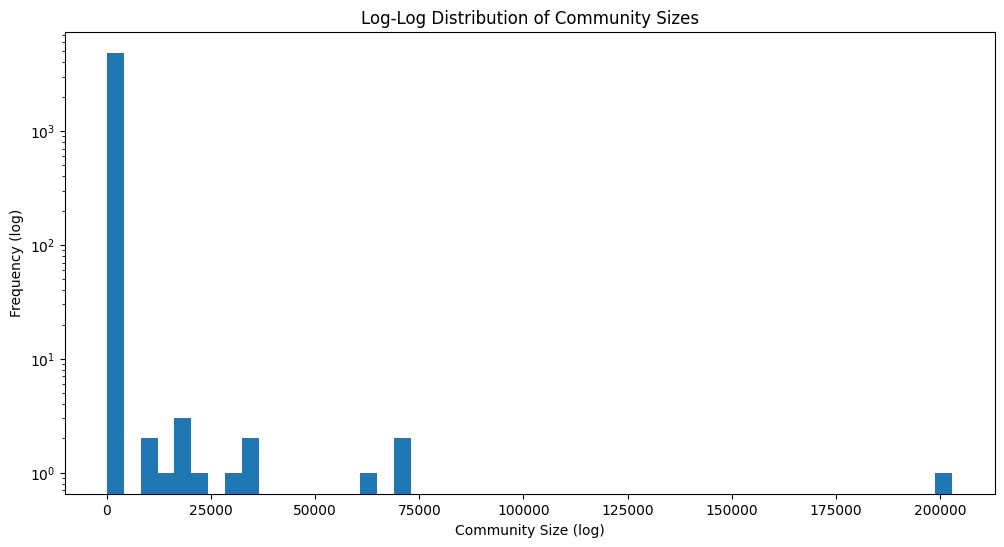

In [ ]:
# log log distribution of community sizes
comm_sizes = np.array(list(community_sizes.values()))
plt.figure(figsize=(12, 6))
plt.hist(comm_sizes, bins=50, log=True)
plt.title("Log-Log Distribution of Community Sizes")
plt.xlabel("Community Size (log)")
plt.ylabel("Frequency (log)")
plt.show()



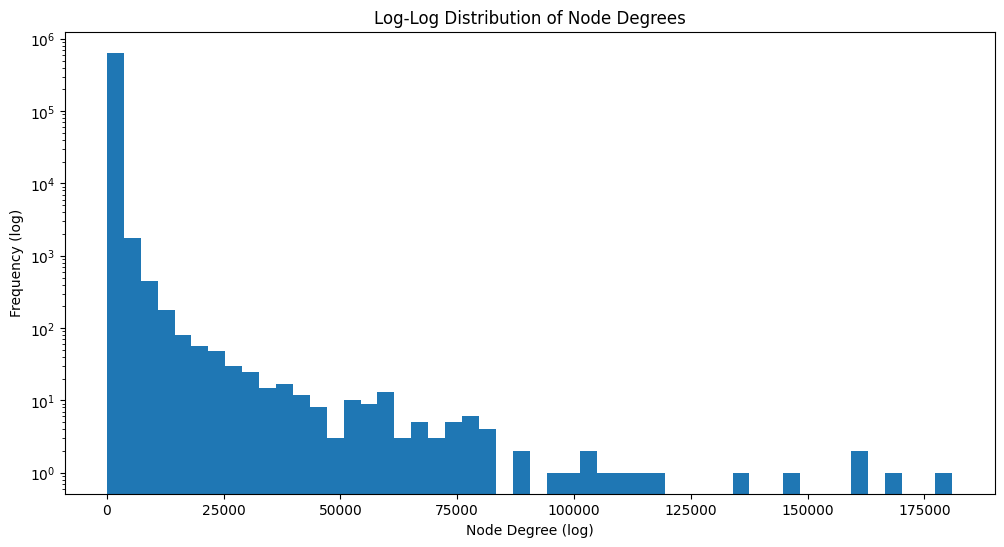

In [ ]:
# degree distribution of the graph
degree_distribution = G.degree()
plt.figure(figsize=(12, 6))
plt.hist(degree_distribution, bins=50, log=True)
plt.title("Log-Log Distribution of Node Degrees")
plt.xlabel("Node Degree (log)")
plt.ylabel("Frequency (log)")
plt.show()


In [ ]:

## 4. Centrality and Bridging Analysis
# Degree centrality
degree_centrality = G.degree()
# Betweenness centrality (approximate for large networks)
betweenness_centrality = G.betweenness(cutoff=1000)

# Role classification and bridging nodes
roles = {}
for node in range(G.vcount()):
    in_deg = G.indegree(nodae)
    out_deg = G.outdegree(node)
    if in_deg > out_deg * 2:
        roles[G.vs[node]['name']] = 'Creator'
    elif out_deg > in_deg * 2:
        roles[G.vs[node]['name']] = 'Consumer'
    else:
        roles[G.vs[node]['name']] = 'Connector'
# Identifying bridging nodes
node_community_links = defaultdict(set)
for edge in G.es:
    comm_u = partition.membership[edge.source]
    comm_v = partition.membership[edge.target]
    if comm_u != comm_v:
        node_community_links[edge.source].add(comm_v)
        node_community_links[edge.target].add(comm_u)
bridging_nodes = {G.vs[node]['name']: len(links) for node, links in node_community_links.items() if len(links) > 1}

# Display top bridging nodes
top_bridging_nodes = sorted(bridging_nodes.items(), key=lambda x: x[1], reverse=True)[:10]
for node, num_comms in top_bridging_nodes:
    print(f"Node: {node}, Connected Communities: {num_comms}")

In [ ]:

## 5. Final Notes and Cleanup
# Free up memory
del users, subs, following, comments, likes, entries
gc.collect()

# Display execution time
end_time = time.time()
total_seconds = end_time - start_time
minutes, seconds = divmod(total_seconds, 60)
print(f"Execution time: {int(minutes)} minutes and {seconds:.2f} seconds")

# Conclusion
print("""
In this optimized notebook, we've:
- Built a memory-efficient graph for community detection.
- Performed community detection using the Leiden algorithm.
- Calculated centrality and role measures.
- Identified bridging nodes across communities.
""")


Execution time: 520 minutes and 14.91 seconds

In this optimized notebook, we've:
- Built a memory-efficient graph for community detection.
- Performed community detection using the Leiden algorithm.
- Calculated centrality and role measures.
- Identified bridging nodes across communities.



In [19]:
# Modularity score - measure of the strength of community structure
modularity_score = partition.modularity
print(f"Modularity Score: {modularity_score:.4f}")

# score of the partition
score = partition.quality()
print(f"Quality Score: {score:.4f}")

Modularity Score: 0.4594
Quality Score: 0.4928


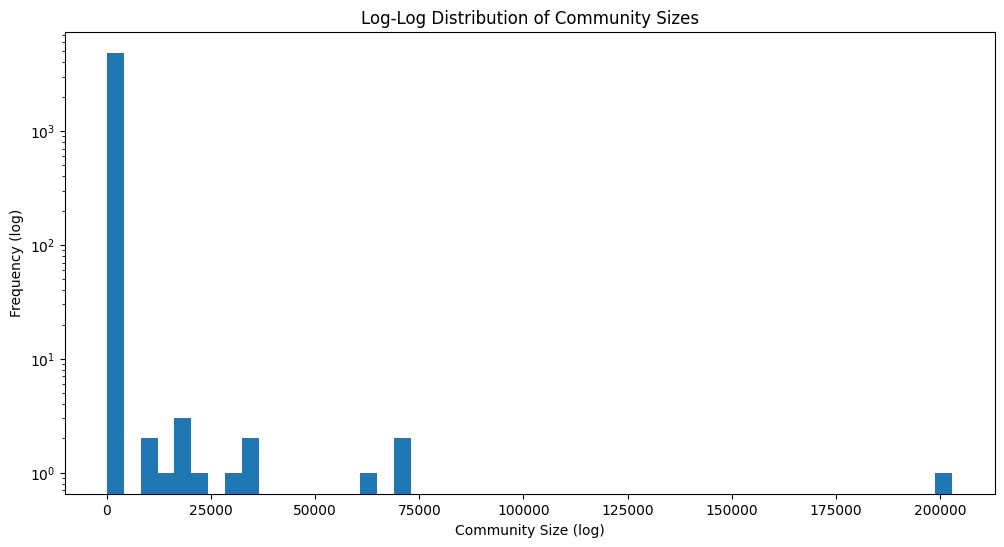

In [16]:
# log log distribution of community sizes
comm_sizes = np.array(list(community_sizes.values()))
plt.figure(figsize=(12, 6))
plt.hist(comm_sizes, bins=50, log=True)
plt.title("Log-Log Distribution of Community Sizes")
plt.xlabel("Community Size (log)")
plt.ylabel("Frequency (log)")
plt.show()



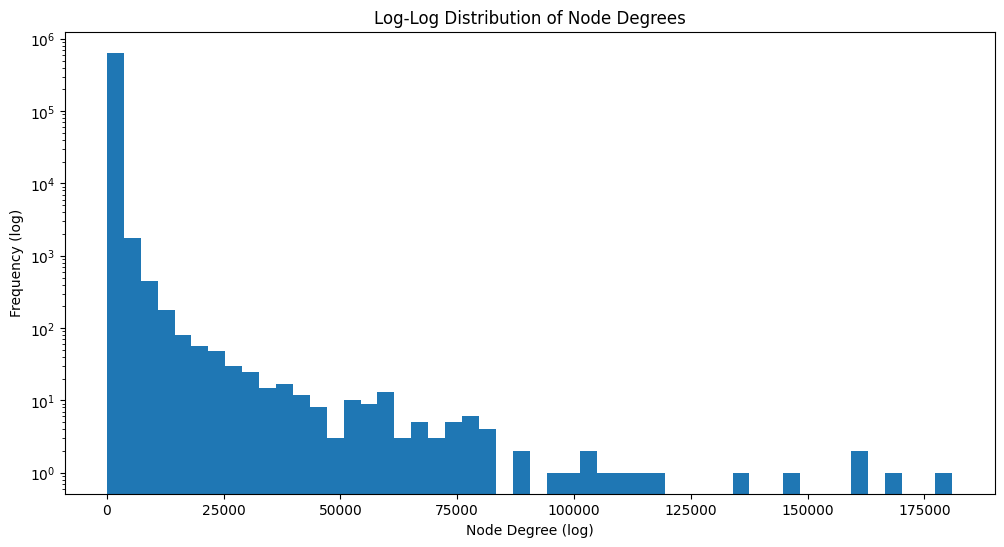

In [30]:
# degree distribution of the graph
degree_distribution = G.degree()
plt.figure(figsize=(12, 6))
plt.hist(degree_distribution, bins=50, log=True)
plt.title("Log-Log Distribution of Node Degrees")
plt.xlabel("Node Degree (log)")
plt.ylabel("Frequency (log)")
plt.show()


In [ ]:

## 4. Centrality and Bridging Analysis
# Degree centrality
degree_centrality = G.degree()
# Betweenness centrality (approximate for large networks)
betweenness_centrality = G.betweenness(cutoff=1000)

# Role classification and bridging nodes
roles = {}
for node in range(G.vcount()):
    in_deg = G.indegree(nodae)
    out_deg = G.outdegree(node)
    if in_deg > out_deg * 2:
        roles[G.vs[node]['name']] = 'Creator'
    elif out_deg > in_deg * 2:
        roles[G.vs[node]['name']] = 'Consumer'
    else:
        roles[G.vs[node]['name']] = 'Connector'
# Identifying bridging nodes
node_community_links = defaultdict(set)
for edge in G.es:
    comm_u = partition.membership[edge.source]
    comm_v = partition.membership[edge.target]
    if comm_u != comm_v:
        node_community_links[edge.source].add(comm_v)
        node_community_links[edge.target].add(comm_u)
bridging_nodes = {G.vs[node]['name']: len(links) for node, links in node_community_links.items() if len(links) > 1}

# Display top bridging nodes
top_bridging_nodes = sorted(bridging_nodes.items(), key=lambda x: x[1], reverse=True)[:10]
for node, num_comms in top_bridging_nodes:
    print(f"Node: {node}, Connected Communities: {num_comms}")

In [48]:

## 5. Final Notes and Cleanup
# Free up memory
del users, subs, following, comments, likes, entries
gc.collect()

# Display execution time
end_time = time.time()
total_seconds = end_time - start_time
minutes, seconds = divmod(total_seconds, 60)
print(f"Execution time: {int(minutes)} minutes and {seconds:.2f} seconds")

# Conclusion
print("""
In this optimized notebook, we've:
- Built a memory-efficient graph for community detection.
- Performed community detection using the Leiden algorithm.
- Calculated centrality and role measures.
- Identified bridging nodes across communities.
""")


Execution time: 20 minutes and 50.67 seconds

In this optimized notebook, we've:
- Built a memory-efficient graph for community detection.
- Performed community detection using the Leiden algorithm.
- Calculated centrality and role measures.
- Identified bridging nodes across communities.

